# Digit Detection with the Masterful CLI Trainer

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_cli_digit_detection.ipynb
[2]:https://docs.masterfulai.com/0.5.2/notebooks/guide_cli_digit_detection.ipynb

In this guide, you will take a first look at Object Detection with the [Masterful CLI Trainer](../notebooks/tutorial_quickstart_cli.ipynb) to train a state of the art model. 

This guide will use a simple dataset of handwritten digits called [YYMNIST](https://github.com/YunYang1994/yymnist). This dataset was created by [Yun Yang](https://github.com/YunYang1994) as the object detection equivalent of [MNIST](http://yann.lecun.com/exdb/mnist/) for classification. It's a wonderful dataset for exploring object detection because its much faster to train and understand than the standard detection datasets like [MSCOCO](https://cocodataset.org/#home).

This guide will also demonstrate the power of using unlabeled data inside the Masterful CLI Trainer.

## Define the Application

In this guide, your challenge is to build a CV model that can take an image with handwritten digits and localize the position of each digit and determine the class of each digit. This example is designed to get you familiar with using the Masterful CLI Trainer to perform different computer vision tasks.

Since you want to identify objects in the image, and their location, the CV task for this problem is **object detection**.

## TL;DR

Don't want to read the rest of this guide, and want to start training
immediately? The following command shows you how to start training
with Masterful, using a configuration file and dataset on S3.

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_with_unlabeled.yaml
```

## Prepare the Data

For this guide, you will use the [YYMNIST](https://github.com/YunYang1994/yymnist) dataset, which is an MNIST-like dataset for Object Detection. In this section, you will take the raw dataset and convert it into a format that Masterful can understand. Along the way, you will visualize a few examples of the data to see both the input to the model, as well as the predictions after training the model.

The original dataset can be generated by following the instructions [here](https://github.com/YunYang1994/yymnist#objection-detection). This will generate a folder of images and a `label.txt` file which contains the bounding box ground truth for each of the images. The label file has a simple format as follows:

```
# image_path x_min, y_min, x_max, y_max, class_id  x_min, y_min ,..., class_id 
```

This label format also happens to match the CSV format for [Masterful Object Detection](../markdown/guide_cli_data_directory_format.md#object-detection), which makes the data conversion task much easier. For your training and test sets, you can use the label file directly, and for your unlabeled set, you simply have to remove all of the bounding box and class information from each line.

Converting each dataset is typically a one-off operation that is different for every dataset you want to train with. For brevity, you can use the already converted dataset located at the public S3 bucket `s3://masterful-public/datasets/yymnist/`. In this bucket, you will see the following files:

```
yymnist\
  test.csv
  train.csv
  unlabeled.csv
  training_with_unlabeled.yaml
  training_no_unlabeled.yaml
  images\
```

### Explore the Data

You should always visually inspect your dataset to get a sense of what the model will see, and to roughly verify that your dataset conversion routine worked properly and you are not training with corrupted or incorrect data. This is especially important for object detection since it is very easy to generate incorrect bounding boxes during dataset conversion.

In [6]:
# Install dependencies necessary to run the following
# code.
!pip install opencv-python-headless --quiet
!pip install masterful --quiet

# Import the packages used below.
import matplotlib.pyplot as plt
import os
import requests
import tarfile
import tempfile
import tensorflow as tf
import urllib.request

# Import and activate the Masterful package.
import masterful
masterful = masterful.activate()

# Helper function to visualize bounding boxes from the dataset
# on the source image.
from masterful.data.visualize import create_annotated_image

# Helper function to display a progress when downloading
# a file using HTTP.
from masterful.utils.downloader import progress_bar_factory

# This is necessary for running inside of Colab/Jupyter,
# since the CLI trainer is run outside of the kernel
# (as a script command).
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.


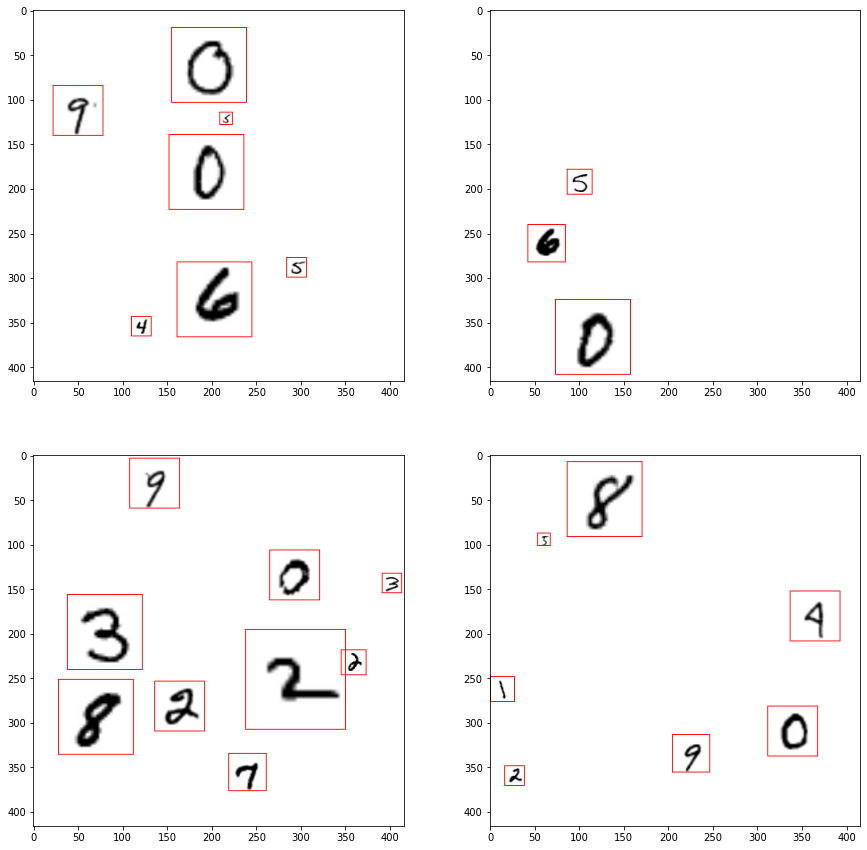

In [7]:
DATASET_ROOT = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/"
TRAINING_CSV_URL = os.path.join(DATASET_ROOT, "train.csv")

with tempfile.TemporaryDirectory() as temp_directory:
  training_csv_name = os.path.join(temp_directory, "train.csv") 
  _ =  urllib.request.urlretrieve(TRAINING_CSV_URL, training_csv_name)

  examples = []
  with open(training_csv_name) as training_csv:
    examples = training_csv.readlines()

f, axarr = plt.subplots(2, 2, figsize=(15,15))
_ = axarr[0, 0].imshow(create_annotated_image(examples[0], DATASET_ROOT))
_ = axarr[0, 1].imshow(create_annotated_image(examples[1], DATASET_ROOT))
_ = axarr[1, 0].imshow(create_annotated_image(examples[2], DATASET_ROOT))
_ = axarr[1, 1].imshow(create_annotated_image(examples[3], DATASET_ROOT))

## Configure the CLI Trainer

The Masterful CLI Trainer is a command line tool that trains a production quality model with no code required. The Masterful CLI Trainer take a [YAML](../markdown/guide_cli_yaml_config.md) configuration file as input. The configuration file fully specifies everything necessary for training, including the dataset, model, export formats, and evaluation metrics.

### Choosing a Model

Masterful provides many different state of the art object detection models that you can choose from. In general, choosing a model can have different constraints than training the model (are you deploying on server or edge? Runtime or latency constraints? Memory constraints?). You generally want to choose a model that is large enough to fit your data, but not so large as to overfit the training data and "memorize" the results, which can lead to poor generalization performance.

The Masterful Object Detection Model Zoo supports the following model architectures.

| Model Name                        | Year | Description                                                                                                                                                                                |
|-----------------------------------|------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `ssd_mobilenet_v1_fpn`            | 2018 | Single-Shot Detector with MobileNet V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                  |
| `ssd_mobilenet_v2`                | 2018 | Single-Shot Detector with MobileNet V2 backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                                  |
| `ssd_mobilenet_v2_fpnlite`        | 2018 | Single-Shot Detector with MobileNet V2 Feature Pyramid Lite backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                             |
| `ssd_resnet50_v1_fpn`             | 2018 | Single-Shot Detector with ResNet-50 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                  |
| `ssd_resnet101_v1_fpn`            | 2018 | Single-Shot Detector with ResNet-101 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                 |
| `ssd_resnet152_v1_fpn`            | 2018 | Single-Shot Detector with ResNet-152 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                 |
| `retinanet_50`                    | 2018 | RetinaNet with ResNet-50 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                             |
| `retinanet_101`                   | 2018 | RetinaNet with ResNet-101 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                            |
| `retinanet_152`                   | 2018 | RetinaNet with ResNet-152 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                            |
| `ssd_efficientdet_d0`             | 2019 | EfficientDet-D0 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d1`             | 2019 | EfficientDet-D1 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d2`             | 2019 | EfficientDet-D2 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d3`             | 2019 | EfficientDet-D3 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d4`             | 2019 | EfficientDet-D4 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d5`             | 2019 | EfficientDet-D5 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d6`             | 2019 | EfficientDet-D6 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d7`             | 2019 | EfficientDet-D7 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `faster_rcnn_resnet50_v1`         | 2016 | Faster R-CNN model with a ResNet-50 V1 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)         |
| `faster_rcnn_resnet101_v1`        | 2016 | Faster R-CNN model with a ResNet-101 V1 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)        |
| `faster_rcnn_resnet152_v1`        | 2016 | Faster R-CNN model with a ResNet-152 V1 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)        |
| `faster_rcnn_inception_resnet_v2` | 2016 | Faster R-CNN model with an Inception ResNet V2 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497) |
| `centernet_hourglass_104`         | 2019 | CenterNet model with an Hourglass-104 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                       |
| `centernet_resnet50_v1_fpn`       | 2019 | CenterNet model with a ResNet-50 V1 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                         |
| `centernet_resnet101_v1_fpn`      | 2019 | CenterNet model with a ResNet-101 V1 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                        |
| `centernet_resnet50_v2`           | 2019 | CenterNet model with a ResNet-50 V2 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                         |
| `centernet_mobilenet_v2_fpn`      | 2019 | CenterNet model with a MobileNet V2 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                         |  


In the example below, you will select a [SSD](https://arxiv.org/abs/1512.02325) model with a [MobileNet-V2](https://arxiv.org/abs/1801.04381) backbone. This model is great for small datasets or for deploying to edge devices, as it is tuned for quick inference at a small cost to overall accuracy.

### The Configuration File

The following section is a condensed YAML configuration file for training against this dataset with **NO** unlabeled data. It points to the dataset created above, and selects a `ssd_mobilenet_v2` model, which is a good model for small datasets and edge inference use cases. 

Note all of the model artifacts will be saved to the directory `~/model_output`, which you can configure in the `output` section below.

The original YAML file can be found [here](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_no_unlabeled.yaml).

```yaml
dataset:
  root_path: https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist
  splits: [train, test]
  label_format: detection_csv
  optimize: True
model:
  architecture: ssd_mobilenet_v2
  num_classes: 10
  input_shape: [416,416,3]
training:
  task: detection
  training_split: train
output:
  formats: [saved_model, onnx]
  path: ~/model_output
evaluation:
  split: test
```

## Train the Model

Training the model involves simply running the Masterful CLI Trainer (`masterful-train`) against the YAML file on S3. As a first step, you will train the model without any additional unlabeled data. This way, you can see the performance improvement later on when you add unlabeled data.

Below, you will setup the CLI and configuration file to run in this notebook. However, if you want to train this model outside of the notebook, against the dataset on S3, you can run:

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_no_unlabeled.yaml
```

NOTE: Object detection models are quite large. Depending on your GPU, this could take several hours to complete, so plan accordingly.

In [1]:
# Use the Masterful CLI to train the model without unlabeled data
!masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_no_unlabeled.yaml

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.
MASTERFUL [12:17:35]: Training with configuration 'https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_no_unlabeled.yaml':
----------  ----------------------------------------------------------------------------------
dataset     root_path     https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist
            splits        ['train', 'test']
            label_format  detection_csv
            optimize      True
model       architecture  ssd_mobilenet_v2
            num_classes   10
            input_shape   [416, 416, 3]
training    task            detection
            training_split  train
output      formats  ['saved_model', 'onnx']
            path     ~/model_output
evaluation  split  test
----------  ----------------------------------------------------------------------------------
MASTERFUL [12:17:36]: Building model 'ssd_mobilenet_v2'...
MASTERFUL [12:17:4

MASTERFUL [12:18:09]: Training dataset learner finished at 12:18:09 in 1 seconds (1s), returned:
-------------------------  -----------------------------
num_classes                10
task                       Task.DETECTION
image_shape                (416, 416, 3)
image_range                ImageRange.ZERO_255
image_dtype                <dtype: 'float32'>
image_channels_last        True
label_dtype                <dtype: 'float32'>
label_shape                (12, 15)
label_structure            TensorStructure.SINGLE_TENSOR
label_sparse               False
label_bounding_box_format  BoundingBoxFormat.TENSORFLOW
-------------------------  -----------------------------
MASTERFUL [12:18:09]: Meta-learning test dataset parameters...
MASTERFUL [12:18:10]: Test dataset learner finished at 12:18:10 in 1 seconds (1s), returned:
-------------------------  -----------------------------
num_classes                10
task                       Task.DETECTION
image_shape                (416, 416, 

MASTERFUL [14:13:03]: Masterful will use 90 labeled examples as a validation set since no validation data was provided.
MASTERFUL [14:13:03]: Training model with:
MASTERFUL [14:13:03]: 	810 labeled examples.
MASTERFUL [14:13:03]: 	90 validation examples.
MASTERFUL [14:13:03]: 	0 synthetic examples.
MASTERFUL [14:13:03]: 	0 unlabeled examples.
MASTERFUL [14:13:04]: Training model with learned parameters bandana-vigorous-daffodil in two phases.
MASTERFUL [14:13:04]: The first phase is supervised training with the learned parameters.
MASTERFUL [14:13:04]: The second phase is semi-supervised training to boost performance.
MASTERFUL [14:13:08]: Warming up model for supervised training.
MASTERFUL [14:13:09]: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL [14:13:12]: 	Warming up training for 250 steps.
100%|██████████████████████████████████████| 250/250 [01:59<00:00,  2.09steps/s]
MASTERFUL [14:15:11]: 	Validating batch norm statistics after warmup for stability

## Analyze the Results

At the end of training, Masterful will evaluate your model based on the test (sometimes called holdout) dataset you specified in the `evaluation` section of your configuration file. The evaluation results are different for each task, since every computer vision task has both general metrics (such as loss) as well as task-specific metrics (IoU for semantic segmentation for example). These results are printed to the console, as well as saved into a CSV file in the output directory specified in your configuration file.

### Object Detection Evaluation Metrics

For Object Detection, Masterful reports three main categories of metrics: Model Loss, COCO Metrics, and Confusion matrix.

#### Model Loss

The first set of metrics Masterful reports is the overall loss of the model. For object detection models, Masterful reports the total loss as well as any sub-losses that are specific to the model architecture. For example, the loss is typically composed of a localization loss (which reflects the location and size of the bounding box) and a classification loss (which reflects which object is in the box). Different models have different sub-losses, and you can gauge how your model is doing on the different tasks based on the final results of these sub-metrics.

The following is the loss results from the above training run (this might be different if you rerun the above cells):  

```
************************************
MASTERFUL [14:32:32]: Evaluating model on 100 examples from the 'test' dataset split:
Evaluating: 100%|█████████████████████████████| 100/100 [00:04<00:00, 24.47it/s]
MASTERFUL [14:32:36]:   Loss: 0.2189
MASTERFUL [14:32:36]:   Loss/Localization Loss: 0.0251
MASTERFUL [14:32:36]:   Loss/Classification Loss: 0.1134
MASTERFUL [14:32:36]:   Loss/Regularization Loss: 0.0803
MASTERFUL [14:32:36]:   Loss/Total Loss: 0.2189
```

As you can see in the above output, the total loss of the model is `MASTERFUL [14:32:36]:   Loss: 0.2189` (which matches the `Loss/Total Loss` output as well). You can check the localization and classification loss as well, and you can see that the classification loss `0.1134` is slightly worse than the localization loss `0.0251`. These seem like pretty good loss values. They are relatively low and close to zero, which is the goal of the optimizer in machine learning training. However, it's really difficult to understand intuitively what these mean in terms of your models overall performance. Are these good values? Or bad ones? Let's dive into the rest of the metrics to answer these questions.



#### COCO Metrics

[Common Objects in Context](https://cocodataset.org/#home) (COCO) is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:

* Object segmentation
* Recognition in context
* Superpixel stuff segmentation
* 330K images (>200K labeled)
* 1.5 million object instances
* 80 object categories
* 91 stuff categories
* 5 captions per image
* 250,000 people with keypoints

The dataset itself is used in many research papers as a standard object detection benchmark. Importantly, COCO also defines a standard set of metrics for evaluating object detection models, commonly called the COCO (MS-COCO) Evaluation Metrics.

The following 12 metrics are used for characterizing the performance of an object detector as part of the COCO detection challenge:

![MSCOCO Metrics](../images/mscoco_metrics.png)

* Unless otherwise specified, AP and AR are averaged over multiple Intersection over Union (IoU) values. Specifically we use 10 IoU thresholds of .50:.05:.95. This is a break from tradition, where AP is computed at a single IoU of .50 (which corresponds to our metric AP<sup>IoU=.50</sup>). Averaging over IoUs rewards detectors with better localization.
* AP is averaged over all categories. Traditionally, this is called "mean average precision" (mAP). We make no distinction between AP and mAP (and likewise AR and mAR) and assume the difference is clear from context.
* AP (averaged across all 10 IoU thresholds and all 80 categories) will determine the challenge winner. This should be considered the single most important metric when considering performance on COCO.
In COCO, there are more small objects than large objects. Specifically: approximately 41% of objects are small (area < 322), 34% are medium (322 < area < 962), and 24% are large (area > 962). Area is measured as the number of pixels in the segmentation mask.
* AR is the maximum recall given a fixed number of detections per image, averaged over categories and IoUs. AR is related to the metric of the same name used in proposal evaluation but is computed on a per-category basis.
* All metrics are computed allowing for at most 100 top-scoring detections per image (across all categories).
* The evaluation metrics for detection with bounding boxes and segmentation masks are identical in all respects except for the IoU computation (which is performed over boxes or masks, respectively).

For more information about things like Average Precision and Recall and IoU in the context of Object Detection, there are several good walkthroughs below with worked examples. They will give you a better intuitive sense of what the metrics are trying to convey: 

[An Introduction to Evaluation Metrics for Object Detection](https://blog.zenggyu.com/en/post/2018-12-16/an-introduction-to-evaluation-metrics-for-object-detection/)  
[Object Detection Metrics With Worked Example](https://towardsdatascience.com/on-object-detection-metrics-with-worked-example-216f173ed31e)

Below, you will find the COCO metrics for the model you trained above:  

```
MASTERFUL [14:32:36]: Calculating MSCOCO evaluation metrics:
MSCOCO Metrics: 100%|█████████████████████████| 100/100 [00:13<00:00,  7.61it/s]
MASTERFUL [14:32:49]:   DetectionBoxes_Precision/mAP: 0.7454
MASTERFUL [14:32:49]:   DetectionBoxes_Precision/mAP@.50IOU: 0.9290
MASTERFUL [14:32:49]:   DetectionBoxes_Precision/mAP@.75IOU: 0.8823
MASTERFUL [14:32:49]:   DetectionBoxes_Precision/mAP (small): 0.6022
MASTERFUL [14:32:49]:   DetectionBoxes_Precision/mAP (medium): 0.8318
MASTERFUL [14:32:49]:   DetectionBoxes_Precision/mAP (large): 0.9343
MASTERFUL [14:32:49]:   DetectionBoxes_Recall/AR@1: 0.6101
MASTERFUL [14:32:49]:   DetectionBoxes_Recall/AR@10: 0.7949
MASTERFUL [14:32:49]:   DetectionBoxes_Recall/AR@100: 0.7949
MASTERFUL [14:32:49]:   DetectionBoxes_Recall/AR@100 (small): 0.6781
MASTERFUL [14:32:49]:   DetectionBoxes_Recall/AR@100 (medium): 0.8705
MASTERFUL [14:32:49]:   DetectionBoxes_Recall/AR@100 (large): 0.9479
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/0: 0.7744
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/1: 0.7481
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/2: 0.7269
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/3: 0.7851
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/4: 0.7444
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/5: 0.7149
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/6: 0.7831
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/7: 0.7767
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/8: 0.6802
MASTERFUL [14:32:49]:   DetectionBoxes_PerformanceByCategory/mAP/9: 0.7204
```

The primary aggregated metric above is `DetectionBoxes_Precision/mAP`, which is the Average Precision calculated over all of the IoU thresholds. Secondarily, the `DetectionBoxes_Precision/mAP@.50IOU` corresponds to the Average Precision at just the 0.5 IoU threshold, which is a good intuitive indicator of performance and corresponds to the older Pascal VOC object detection metrics. The models scores relatively high on both of these metrics (`0.7454` and `0.9290`) respectively. As you can see in the per-category metrics (`DetectionBoxes_PerformanceByCategory`), the model scores decently well across all of the different classes, with the worst performance on digit `8` and the best performance on digit `3`.


#### Confusion Matrix

The final set of metrics Masterful provides for Object Detection is the confusion matrix of predictions versus labels. The confusion matrix helps figure out where and how the model makes mistakes.  

Below is the output for the confusion matrix from the training process:  

```
MASTERFUL [14:33:00]:   Confusion Matrix:
MASTERFUL [14:33:00]:           |    0|    1|    2|    3|    4|    5|    6|    7|    8|    9| background|
MASTERFUL [14:33:00]:          0|   64|    0|    0|    0|    0|    0|    0|    0|    1|    0|          5|
MASTERFUL [14:33:00]:          1|    0|   55|    0|    0|    0|    0|    0|    0|    0|    0|          2|
MASTERFUL [14:33:00]:          2|    0|    0|   34|    5|    0|    0|    0|    0|    0|    1|          4|
MASTERFUL [14:33:00]:          3|    0|    0|    2|   57|    0|    0|    0|    0|    0|    1|          2|
MASTERFUL [14:33:00]:          4|    0|    1|    0|    0|   59|    0|    1|    2|    0|    5|          6|
MASTERFUL [14:33:00]:          5|    0|    0|    1|    0|    1|   53|    0|    0|    1|    0|          4|
MASTERFUL [14:33:00]:          6|    0|    1|    0|    0|    0|    0|   62|    0|    1|    0|          2|
MASTERFUL [14:33:00]:          7|    0|    1|    2|    1|    1|    0|    0|   63|    0|    6|          4|
MASTERFUL [14:33:00]:          8|    1|    0|    0|    2|    0|    2|    2|    0|   40|    3|          5|
MASTERFUL [14:33:00]:          9|    0|    0|    0|    1|    2|    0|    0|    1|    0|   49|          6|
MASTERFUL [14:33:00]: background|    0|    2|    2|    4|    3|    2|    0|    4|    2|    4|          0|
MASTERFUL [14:33:00]:     Confusion matrix columns represent the prediction labels and the rows represent
                          the real labels.
```

In the above output, the columns represent the predictions made for the model. So the `3` column represents all of the examples where the model predicted `3`. For this column, each row represents the label in the dataset. So for the `3` column, the row `3` represents all of the examples where the model predicted `3` and the label in the dataset was also `3`. These are considered the **true positives** - the examples where the model made a correct positive prediction. In the `3` column, the `7` row represents the examples where the model predicted `3`, but the true label was actually `7`. These are considered **false positives** - examples where the model correctly detected an object but predicted the wrong class. However, because a detection task requires **both** correctly identifying the presence of an object as well as correctly classifying the type of that object, it is possible that the model predicts the existence of an object that does not exist. This is quantified in the `background` row of the above matrix. For example, In the `3` column, the `background` cell represents all of the examples where the model predicted a `3`, but there was no actual `3` in that location or image. These are **false postives** where the model predicted the incorrect existence of a `3`, rather than correctly predicting the existence but mis-categorizing the object instance. But if the `background` row contains predictions where there should not have been any, what does the `background` column represent? The `background` column represents predictions that were **not** made. In other words, for the `background` column and `3` row, this cell represents the examples where a `3` existed but the model failed to predict a `3` at this position. This represents a `false negative` prediction from the model.

As you can see, the diagonal of the confusion matrix represents all of the correct positive predictions of the model. The off-diagonals represent different mistakes the model made in its predictions.

In the above explanation, you have see the location of the `true positives` (the diagonals) and the location of the `false positives` (off-diagonals) and `false negatives` (`background` column). One question you might ask, is where are the `true negatives` - the examples where there were no instances of an object and the model correctly made no predictions? There are two ways to interpret `false negatives` from the above matrix. The first is as `true positives` on the `background` class - the diagonal entry in the `background` column and row. These are the instances in the dataset with no objects and the model correctly predicted no objects. In this dataset however, every example has an object. You can see this in the test dataset analysis output for the `Num Empty Images (No Labels)` row:  

```
MASTERFUL [12:18:08]: Test dataset analysis
-----------------------------  ----------------------------------------
Total Examples                 100
Label Counts                   0  70
                               1  57
                               2  44
                               3  62
                               4  74
                               5  60
                               6  66
                               7  78
                               8  55
                               9  59
.
.
.
Num Empty Images (No Labels):  0
Total Objects                  625
```

Another way to categorize `true negatives` is that every `true positive` on one class is a corresponding `true negative` on another class - correctly predicting the existence of one class is also correctly predicting the absence of another class, or all other classes. However, neither of these definitions provide much value, and importantly they can overestimate derived metrics. For example, `accuracy` is commonly defined as the number of "correct" predictions (`true positives` plus `true negatives`) over the total number of objects. In object detection however, this will drastically over-estimate the accuracy of the model given the presence of the `true negatives` term, which when averaged over all of the classes you would most likely end up with more `true negatives` than object instances in the dataset. This is historically why object detection has relied on `precision` and `recall` metrics, rather than `accuracy`, due to the lack of a `true negative` term in the definition of the former.  

### View the Predictions

While the mAP metrics are a good quantitative indicator of the performance of your model, visualizing the predictions can help you get a qualititative sense of how well your trained model is performing. Below you can see the predictions for the above trained model has on the examples you visualized above. The red boxes are the labels from the dataset, and the green boxes are the predictions made by the model.

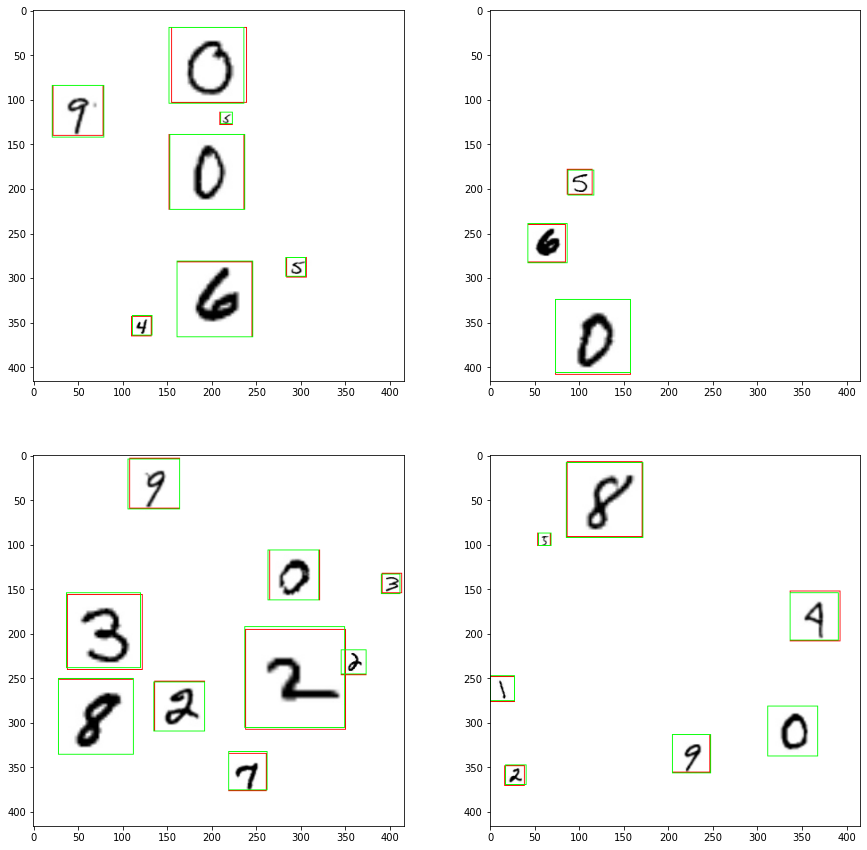

In [5]:
# Download the pretrained model so that you can
# visualize the results.
MODEL_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/yymnist_no_unlabeled_saved_model.tar.gz"

model = None
with tempfile.TemporaryDirectory() as temp_directory:
  # Download the pretrained model from S3.
  saved_model_path = os.path.join(temp_directory, "saved_model.tar.gz") 
  _ =  urllib.request.urlretrieve(MODEL_URL, saved_model_path, progress_bar_factory("Downloading Model: "))

  # Extract the model weights from the tar file.
  with tarfile.open(saved_model_path) as tar:
    tar.extractall(temp_directory)
  saved_model_path = os.path.join(temp_directory, "saved_model") 

  # Load the trained tensorflow saved model.
  model = tf.saved_model.load(saved_model_path)
  
  # Plot a few different instances from the dataset.
  f, axarr = plt.subplots(2, 2, figsize=(15,15))
  _ = axarr[0, 0].imshow(create_annotated_image(examples[0], DATASET_ROOT, model))
  _ = axarr[0, 1].imshow(create_annotated_image(examples[1], DATASET_ROOT, model))
  _ = axarr[1, 0].imshow(create_annotated_image(examples[2], DATASET_ROOT, model))
  _ = axarr[1, 1].imshow(create_annotated_image(examples[3], DATASET_ROOT, model))

As you can see in the above predictions, the model performs exceptionally well in localizing all of the the different digits! The predicted bounding boxes (green) are tight against the ground truth bounding boxes (red) and no digits are missing and there are no predictions in areas with no digits.

## Improve Your Model with Unlabeled Data

The performance of your model above was great, but can you do better? The answer is yes, by adding unlabeled data! Below, you will retrain your model with an additional unlabeled data split. Adding unlabeled data is easy. The CSV file just lists the images without any labels. For example, here are the first few items from [unlabeled.csv](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/unlabeled.csv), which lists all of the unlabeled training items.

```
images/extra/001001.jpg
images/extra/001002.jpg
images/extra/001003.jpg
images/extra/001004.jpg
images/extra/001005.jpg
images/extra/001006.jpg
images/extra/001007.jpg
images/extra/001008.jpg
images/extra/001009.jpg
images/extra/001010.jpg
.
.
.
```

You will also point to a new YAML file [training_with_unlabeled.yaml](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_with_unlabeled.yaml) which add the above unlabeled data to the training process. There are only two differences in this yaml versus the one you just trained with. First, you let the dataset configuration know about the unlabeled data: 

```yaml
dataset:
    splits: [train, test, unlabeled]
```

Second, you tell the training process to use that split: 

```yaml
training:
  task: detection
  training_split: train
  unlabeled_split: unlabeled
```

If you want to run the trainer with unlabeled data outside of this notebook, you can simply run the following command: 

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_with_unlabeled.yaml
```
Otherwise, you can run the following cell:

In [2]:
# Use the Masterful CLI to train the model WITH unlabeled data
!masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_with_unlabeled.yaml

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.
MASTERFUL [14:34:42]: Training with configuration 'https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/training_with_unlabeled.yaml':
----------  ----------------------------------------------------------------------------------
dataset     root_path     https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist
            splits        ['train', 'test', 'unlabeled']
            label_format  detection_csv
            optimize      True
model       architecture  ssd_mobilenet_v2
            num_classes   10
            input_shape   [416, 416, 3]
training    task             detection
            training_split   train
            unlabeled_split  unlabeled
output      formats  ['saved_model', 'onnx']
            path     ~/model_output
evaluation  split  test
----------  ----------------------------------------------------------------------------------
MASTERFUL [14:34:43]:

MASTERFUL [14:36:41]: Training dataset learner finished at 14:36:41 in 1 seconds (1s), returned:
-------------------------  -----------------------------
num_classes                10
task                       Task.DETECTION
image_shape                (416, 416, 3)
image_range                ImageRange.ZERO_255
image_dtype                <dtype: 'float32'>
image_channels_last        True
label_dtype                <dtype: 'float32'>
label_shape                (12, 15)
label_structure            TensorStructure.SINGLE_TENSOR
label_sparse               False
label_bounding_box_format  BoundingBoxFormat.TENSORFLOW
-------------------------  -----------------------------
MASTERFUL [14:36:41]: Meta-learning test dataset parameters...
MASTERFUL [14:36:41]: Test dataset learner finished at 14:36:41 in 1 seconds (1s), returned:
-------------------------  -----------------------------
num_classes                10
task                       Task.DETECTION
image_shape                (416, 416, 

MASTERFUL [16:21:44]: SSL learner finished at 16:21:44 in 1 seconds (1s), returned:
-------------------------  -------------------
num_classes                10
task                       Task.DETECTION
image_shape                (416, 416, 3)
image_range                ImageRange.ZERO_255
image_dtype                <dtype: 'float32'>
image_channels_last        True
label_dtype
label_shape
label_structure
label_sparse               False
label_bounding_box_format
-------------------------  -------------------
MASTERFUL [16:21:45]: Training model with semi-supervised learning enabled.
MASTERFUL [16:21:45]: Performing basic dataset analysis.
MASTERFUL [16:21:55]: Masterful will use 90 labeled examples as a validation set since no validation data was provided.
MASTERFUL [16:21:55]: Training model with:
MASTERFUL [16:21:55]: 	810 labeled examples.
MASTERFUL [16:21:55]: 	90 validation examples.
MASTERFUL [16:21:55]: 	0 synthetic examples.
MASTERFUL [16:21:55]: 	9000 unlabeled examples.
MAST

## Unlabeled Data Improved Model Training

In the below table is a summary of the evaluation metrics from both training runs, with and without unlabeled data:  

| Metric          | Without Unlabeled Data | With Unlabeled Data |
|-----------------|------------------------|---------------------|
| `Loss`          | 0.2189                 | 0.1950              |
| `mAP`           | 0.7454                 | 0.7625              |
| `mAP@0.5`       | 0.9290                 | 0.9311              |
| `mAP - Class 0` | 0.7744                 | 0.7844              |
| `mAP - Class 1` | 0.7481                 | 0.8332              |
| `mAP - Class 2` | 0.7269                 | 0.7457              |
| `mAP - Class 3` | 0.7851                 | 0.7791              |
| `mAP - Class 4` | 0.7444                 | 0.7758              |
| `mAP - Class 5` | 0.7149                 | 0.7530              |
| `mAP - Class 6` | 0.7831                 | 0.7673              |
| `mAP - Class 7` | 0.7767                 | 0.7604              |
| `mAP - Class 8` | 0.6802                 | 0.7213              |
| `mAP - Class 9` | 0.7204                 | 0.7052              |

As you can see, the overall loss improved and the mAP metrics improved. From the per-category metrics, the model significantly improved on the worst performing classes. It did this at a small expense to the best-performing classes, which is okay because the model was already good at those, and by improving the worst performing classes the model got better overall!

## Using the Model for Inference

The [Output Formats](../markdown/guide_cli_model_output_formats.md) guide has more information about how to use the models output by Masterful. Object Detection has a few other intricacies that should be addressed though, since the model outputs both the location of an object, a class instance for that object, and a measure of the confidence in the prediction. First, the below code shows how to make a prediction using the model we loaded above on the examples you visualized in the [View the Predictions](#view-the-predictions) section:

In [9]:
# This image corresponds to the first image (upper left)
# in the `View the Predictions` section above.
IMAGE_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/images/train/000001.jpg"

# Load the trained model so that you can test running inference.
MODEL_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/yymnist/yymnist_with_unlabeled_saved_model.tar.gz"

model = None
with tempfile.TemporaryDirectory() as temp_directory:
  # Download the pretrained model from S3.
  saved_model_path = os.path.join(temp_directory, "saved_model.tar.gz") 
  _ =  urllib.request.urlretrieve(MODEL_URL, saved_model_path, progress_bar_factory("Downloading Model: "))

  # Extract the model weights from the tar file.
  with tarfile.open(saved_model_path) as tar:
    tar.extractall(temp_directory)
  saved_model_path = os.path.join(temp_directory, "saved_model") 

  # Load the trained tensorflow saved model.
  model = tf.saved_model.load(saved_model_path)

# Download the image to use for generating a prediction
# and convert it into a tensor.
http_response = requests.get(IMAGE_URL, stream=True)
image = tf.io.decode_image(http_response.raw.read())

image_height = image.shape[0]
image_width = image.shape[1]
print(f"Image Shape: height={image_height} width={image_width}.")

# The default inference function for tensorflow saved
# models is named `serving_default`.
inference_fn = model.signatures["serving_default"]

# The inference function is a one-arg callable, whose
# input argument is `image` - the image to predict on,
# and which returns a dictionary of outputs. The dictionary
# contains an item whose key is `prediction`, which is the
# predictions of the model.
predictions = inference_fn(image=image)['prediction']

# Convert the predictions to NumPY for easier processing.
predictions = predictions.numpy()

# The predictions from an object detection model
# have the shape [batch size, number of boxes, 6]. 
# The batch size will always be 1 for inference models,
# since they expect only one image for to predict on.
# The number of boxes predicted depends on the model
# configuration and represents the maximum number of boxes
# predicted for each example. A typical value is 100.
print(f"Predictions shape is {predictions.shape}")
print(f"Maximum number of boxes predicted is {predictions.shape[1]}")

# The final dimension of the prediction represents the boxes,
# classes, and confidences predicted by the model. This dimension
# is of form: [ymin, xmin, ymax, xmax, class id, confidence].
# The box values are normalized against the image size, and are
# in the range [0,1].
#
# The confidence score is a value in the range [0,1] which represents 
# the confidence of the prediction, similar to the confidence
# of a classification model represented by the softmax probabities
# of the class predictions. The step to determingin the `true`
# predictions is to threshold the predictions by the confidence
# score. A typical scheme is to use only the predictions whose
# confidence is greater than 0.5 as the threshold, but you can
# experiment with different threshold values for your use case.
threshold = 0.5
true_predictions = predictions[predictions[:, :, 5] > threshold]
print(f"Found {true_predictions.shape[1]} confident predictions out of {predictions.shape[1]} total predictions.")

# Print the model predictions above the given threshold
for i in range(true_predictions.shape[0]):
  print(f"Prediction {i}:")
  print(f"  Class:  {int(true_predictions[i][4])}")
  print(f"  Left:   {int(true_predictions[i][1]*image_width)}")
  print(f"  Top:    {int(true_predictions[i][0]*image_height)}")
  print(f"  Right:  {int(true_predictions[i][3]*image_width)}")
  print(f"  Bottom: {int(true_predictions[i][2]*image_height)}")

Image Shape: height=416 width=416.
Predictions shape is (1, 100, 6)
Maximum number of boxes predicted is 100
Found 6 confident predictions out of 100 total predictions.
Prediction 0:
  Class:  0
  Left:   154
  Top:    137
  Right:  241
  Bottom: 223
Prediction 1:
  Class:  6
  Left:   162
  Top:    282
  Right:  247
  Bottom: 366
Prediction 2:
  Class:  0
  Left:   155
  Top:    21
  Right:  241
  Bottom: 106
Prediction 3:
  Class:  5
  Left:   284
  Top:    277
  Right:  306
  Bottom: 299
Prediction 4:
  Class:  5
  Left:   208
  Top:    115
  Right:  223
  Bottom: 130
Prediction 5:
  Class:  9
  Left:   23
  Top:    84
  Right:  78
  Bottom: 140
Prediction 6:
  Class:  4
  Left:   109
  Top:    342
  Right:  132
  Bottom: 365


## Next Steps

In the above sections, you have learned how to train an object detection model using the Masterful CLI, evaluate the performance of the model, and use the model to make predictions on your production data.

If you want to look at another, more involved Object Detection example, see [Detecting Pedestrians in Street Level Imagery](../notebooks/guide_cli_object_detection_pedestrians.ipynb) for more information. Otherwise, feel free to explore [Classifying Land Use](../notebooks/guide_cli_classification_land_use.ipynb) and [Segmenting Animals](../notebooks/guide_cli_semantic_segmentation.ipynb) for other examples of using the Masterful CLI Trainer to solve challenging computer vision problems.